# Learning Molecular Representation using Graph Neural Network

In this notebook, I will be trying to recreate the molecular property predictor model, [Chemprop](https://github.com/chemprop/chemprop), utilizing graph neural networks. Chemprop adopts a variant of graph neural network called **"directed message passing neural network (D-MPNN)"**. 

In [21]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from io import BytesIO
import pandas as pd
import numpy as np
import threading
from random import Random
from IPython.display import SVG
import svgutils.compose as sc
import svgutils.transform as sg
from ipywidgets import interact, interactive, fixed

# Import RDKit libraries for chemistry functions
import rdkit
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole # Needed to display molecules in Jupyter
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions # Used for custom drawing options

# Set drawing options for molecular visualization
DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True  # Use SVG for high-quality molecular graphics
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')  # Disable RDKit warnings for cleaner output
print(rdkit.__version__)  # Display the version of RDKit

# Import PyTorch libraries for model building
import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, Optimizer
from torch import nn

from sklearn.metrics import mean_squared_error

# Import additional utilities
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple
from tqdm.notebook import tqdm  # For displaying progress bars
from functools import reduce  # For functional programming tools

2023.09.5


## Defining necessary functions and classes

In [22]:
# Define a class to store training arguments and settings
class TrainArgs:
    """Container for training parameters and model configuration."""
    smiles_column = None  # Column name for SMILES strings, to be set later
    num_workers = 8       # Number of worker threads for loading data
    batch_size = 50       # Batch size for training
    no_cache_mol = False  # Toggle whether to cache molecule objects
    dataset_type = 'regression'  # Type of dataset/task, regression in this case
    task_names = []       # Names of the tasks, to be populated based on the dataset
    seed = 0              # Random seed for reproducibility
    hidden_size = 300     # Hidden layer size for the neural network
    bias = False          # Use bias in neural network layers
    depth = 3             # Depth of the network (number of layers)
    dropout = 0.0         # Dropout rate for training
    undirected = False    # Whether the molecular graph is undirected
    aggregation = 'mean'  # Method for aggregating node information
    aggregation_norm = 100  # Normalization factor for aggregation
    ffn_num_layers = 2    # Number of layers in the feed-forward network
    ffn_hidden_size = 300 # Hidden layer size of the feed-forward network
    init_lr = 1e-4        # Initial learning rate
    max_lr = 1e-3         # Maximum learning rate
    final_lr = 1e-4       # Final learning rate
    num_lrs = 1           # Number of different learning rates to use
    warmup_epochs = 2.0   # Number of epochs to linearly increase the learning rate
    epochs = 30           # Total number of epochs to train
    device = torch.device('cpu')  # Device to run the model on, default to CPU

In [23]:
# Instantiate and configure the training arguments
args = TrainArgs()
args.data_path = '../data/enamine_discovery_diversity_set_10240.csv'
args.target_column = 'ClogP'  # Column name for the property to predict
args.smiles_column = 'SMILES'  # Column name for SMILES strings
args.dataset_type = 'regression'  # Type of learning task
args.task_names = [args.target_column]  # List of tasks to train on
args.num_tasks = 1  # Number of tasks, one in this case since only predicting ClogP

In [24]:
# Initialize the caches for graphs and RDKit molecule objects
CACHE_GRAPH = True
SMILES_TO_GRAPH = {}  # Cache to store pre-computed graph objects from SMILES

def cache_graph():
    """Check if graph caching is enabled."""
    return CACHE_GRAPH

def set_cache_graph(cache_graph: bool):
    """Enable or disable graph caching."""
    global CACHE_GRAPH
    CACHE_GRAPH = cache_graph

CACHE_MOL = True
SMILES_TO_MOL: Dict[str, Chem.Mol] = {}  # Cache to store RDKit molecule objects from SMILES

def cache_mol() -> bool:
    """Check if molecule caching is enabled."""
    return CACHE_MOL

def set_cache_mol(cache_mol: bool):
    """Enable or disable molecule caching."""
    global CACHE_MOL
    CACHE_MOL = cache_mol

### Defining Atomic and Bond Features
The `atom_features` and `bond_features` functions are being used to define the atomic and bond features which will be the node and edge features of the graph neural network. The atom feature vector consists of one-hot encoding of atomic number, degree, formal charge, chirality, number of hydrogens, and hybridization. And the bond feature vector consists of one-hot encoding of bond type (single, double, triple, aromatic) and whether the bond is conjugated or not and whether in the ring or not.

In [25]:
# Define features for atoms and bonds in molecules
MAX_ATOMIC_NUM = 100  # Maximum number of atomic numbers to consider for encoding
ATOM_FEATURES = {
    'atomic_num': list(range(MAX_ATOMIC_NUM)),
    'degree': [0, 1, 2, 3, 4, 5],  # Degrees of connectivity for an atom
    'formal_charge': [-1, -2, 1, 2, 0],  # Possible formal charges on an atom
    'chiral_tag': [0, 1, 2, 3],  # Chirality tags
    'num_Hs': [0, 1, 2, 3, 4],  # Number of hydrogen atoms attached
    'hybridization': [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],  # Hybridization states
}

PATH_DISTANCE_BINS = list(range(10))  # Binning for path distances in the molecular graph
THREE_D_DISTANCE_MAX = 20  # Maximum distance for 3D spatial features
THREE_D_DISTANCE_STEP = 1  # Step size for incrementing distance
THREE_D_DISTANCE_BINS = list(range(0, THREE_D_DISTANCE_MAX + 1, THREE_D_DISTANCE_STEP))

# len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
ATOM_FDIM = sum(len(choices) + 1 for choices in ATOM_FEATURES.values()) + 2
EXTRA_ATOM_FDIM = 0
BOND_FDIM = 14

In [26]:
def get_atom_fdim() -> int:
    """Calculate the dimensionality of atom features."""
    return sum(len(choices) + 1 for choices in ATOM_FEATURES.values()) + 2  # Additional features for aromaticity and mass

def get_bond_fdim(atom_messages=False) -> int:
    """Calculate the dimensionality of bond features."""
    return BOND_FDIM + (not atom_messages) * get_atom_fdim()

def onek_encoding_unk(value: int, choices: List[int]):
    """One-hot encode a value with a provision for unknown values."""
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

In [27]:
def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None):
    """Build a feature vector for an atom based on its chemical properties."""
    features = onek_encoding_unk(atom.GetAtomicNum() - 1, ATOM_FEATURES['atomic_num']) + \
               onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) + \
               onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) + \
               onek_encoding_unk(int(atom.GetChiralTag()), ATOM_FEATURES['chiral_tag']) + \
               onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) + \
               onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) + \
               [1 if atom.GetIsAromatic() else 0] + \
               [atom.GetMass() * 0.01]  # Mass is scaled for feature consistency
    if functional_groups is not None:
        features += functional_groups
    return features

In [28]:
def bond_features(bond: Chem.rdchem.Bond):
    """Build a feature vector for a bond based on its chemical properties."""
    if bond is None:
        return [1] + [0] * (BOND_FDIM - 1)  # Handle the case of non-existent bonds
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # Bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            bond.GetIsConjugated() if bt is not None else 0,
            bond.IsInRing() if bt is not None else 0
        ] + onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
        return fbond

#### Visualizing molecular graph with atoms and bonds features
Below is an example molecule to see how atom and bond features actually look like

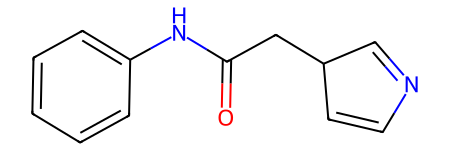

In [29]:
# Creating a moleuclar graph
smiles = 'c1ccccc1NC(=O)CC1cncc1'
mol = Chem.MolFromSmiles(smiles)
mol

Below is an interactive visualization of the feature vector of every atoms in the molecule. The first 100 elements represents the atomic number, followed by one hot encodings of degree (2), formal charge (0), chiral (false), total number of Hs (1), hybridization (SP2), aromaticity (1). Finally atomic mass (multiplied by 0.01) at the last entry.

In [30]:
def drawit(m, atomId=0):
    atom = m.GetAtomWithIdx(atomId)
    feat = atom_features(atom)
    
    # draw molecule with highlight
    d = rdMolDraw2D.MolDraw2DSVG(200, 150)
    rdMolDraw2D.PrepareAndDrawMolecule(d, m, highlightAtoms=(atom.GetIdx(),))
    d.FinishDrawing()
    mol_svg = d.GetDrawingText()
    
    # draw feature
    fig = plt.figure(figsize=(3, 0.8), dpi=150)
    ax = fig.add_subplot(111)
    im = ax.imshow([feat], interpolation='nearest', cmap='viridis', aspect='auto')
    plt.xlabel('atom feature')
    ax.set_yticks([])
    img = BytesIO()
    plt.tight_layout()
    plt.savefig(img, transparent=True, format='svg')
    plt.close(fig)
    feat_svg = img.getvalue().decode()
    
    # arrange figures
    fig1 = sg.fromstring(mol_svg)
    fig2 = sg.fromstring(feat_svg)
    plot1 = fig1.getroot()
    plot2 = fig2.getroot()
    plot1.moveto(10, -40)
    plot2.moveto(0, 65)

    svg = sc.Figure("16cm", "6cm", 
            plot1.scale(0.05), 
            plot2.scale(0.05), 
          ).tostr()
    return SVG(svg)
    
interact(drawit, m=fixed(mol), atomId=(0, mol.GetNumAtoms()-1));

interactive(children=(IntSlider(value=0, description='atomId', max=14), Output()), _dom_classes=('widget-inter…

As seen from the representation, the atom index 0 and 7 are very similar since they are both carbon atoms and only slightly different in terms of aromaticity and the number of hydrogens attached.

### Graph Featurization
The `MolGraph` iterates over atoms and bonds and stores atom feature and bond feature vectors into f_atoms and f_bonds attributes and construct neighboring atom indices.

In [31]:
class MoleculeDatapoint:
    """
    Represents a single molecule's data including features, targets, and its SMILES string.
    """
    def __init__(self, smiles: str, targets: List[Optional[float]] = None, row: OrderedDict = None):
        """
        Initializes a MoleculeDatapoint instance.
        Args:
            smiles (str): The SMILES string representing the molecule.
            targets (List[Optional[float]]): The target properties to predict.
            row (OrderedDict): Row from the dataset containing additional data.
        """
        self.smiles = smiles
        self.targets = targets
        self.features = []
        self.row = row

    @property
    def mol(self) -> Chem.Mol:
        """
        Lazy loads and returns the RDKit molecule object corresponding to the SMILES string.
        Caches the molecule if caching is enabled.
        """
        mol = SMILES_TO_MOL.get(self.smiles, Chem.MolFromSmiles(self.smiles))
        if cache_mol():
            SMILES_TO_MOL[self.smiles] = mol
        return mol

    def set_features(self, features: np.ndarray) -> None:
        """Sets the molecule's features."""
        self.features = features

    def extend_features(self, features: np.ndarray) -> None:
        """Appends additional features to the molecule's feature array."""
        self.features = np.append(self.features, features) if self.features is not None else features

    def num_tasks(self) -> int:
        """Returns the number of prediction tasks based on the targets list."""
        return len(self.targets)

    def set_targets(self, targets: List[Optional[float]]):
        """Sets the prediction targets for the molecule."""
        self.targets = targets

    def reset_features_and_targets(self) -> None:
        """Resets the features and targets to their original values."""
        self.features, self.targets = self.raw_features, self.raw_targets

In [32]:
class MoleculeDataset(Dataset):
    """
    PyTorch dataset class for handling collections of MoleculeDatapoints.
    """
    def __init__(self, data: List[MoleculeDatapoint]):
        """
        Initializes a MoleculeDataset instance.
        Args:
            data (List[MoleculeDatapoint]): List of molecule data points.
        """
        self._data = data
        self._scaler = None
        self._batch_graph = None
        self._random = Random()

    def smiles(self) -> List[str]:
        """Returns a list of SMILES strings for all molecules in the dataset."""
        return [d.smiles for d in self._data]

    def mols(self) -> List[Chem.Mol]:
        """Returns a list of RDKit molecule objects for all molecules in the dataset."""
        return [d.mol for d in self._data]

    def targets(self) -> List[List[Optional[float]]]:
        """Returns a list of target properties for all molecules in the dataset."""
        return [d.targets for d in self._data]

    def num_tasks(self) -> int:
        """Returns the number of tasks based on the first data point, assuming uniformity."""
        return self._data[0].num_tasks() if len(self._data) > 0 else None

    def set_targets(self, targets: List[List[Optional[float]]]) -> None:
        """
        Sets the target properties for each molecule in the dataset.
        Args:
            targets (List[List[Optional[float]]]): Nested list of target values.
        """
        assert len(self._data) == len(targets)
        for i in range(len(self._data)):
            self._data[i].set_targets(targets[i])

    def reset_features_and_targets(self) -> None:
        """Resets features and targets for all molecules in the dataset to their original values."""
        for d in self._data:
            d.reset_features_and_targets()

    def __len__(self) -> int:
        """Returns the number of molecules in the dataset."""
        return len(self._data)

    def __getitem__(self, item) -> Union[MoleculeDatapoint, List[MoleculeDatapoint]]:
        """Returns the molecule data point or a list of data points indexed by item."""
        return self._data[item]

    def batch_graph(self):
        """
        Prepares and caches the graph representation for a batch of molecules, if not already cached.
        """
        if self._batch_graph is None:
            self._batch_graph = []
            mol_graphs = []
            for d in self._data:
                mol_graphs_list = []
                if d.smiles in SMILES_TO_GRAPH:
                    mol_graph = SMILES_TO_GRAPH[d.smiles]
                else:
                    mol_graph = MolGraph(d.mol)
                    if cache_graph():
                        SMILES_TO_GRAPH[d.smiles] = mol_graph
                mol_graphs.append([mol_graph])
            self._batch_graph = [BatchMolGraph([g[i] for g in mol_graphs]) for i in range(len(mol_graphs[0]))]
        return self._batch_graph

    def features(self) -> List[np.ndarray]:
        """
        Returns the features associated with each molecule (if they exist).

        :return: A list of 1D numpy arrays containing the features for each molecule or None if there are no features.
        """
        if len(self._data) == 0 or self._data[0].features is None:
            return None

        return [d.features for d in self._data]

In [33]:
def index_select_ND(source: torch.Tensor, index: torch.Tensor) -> torch.Tensor:
    """Selects the message features from source corresponding to the atom or bond indices in index.
    """
    index_size = index.size()             # (num_atoms/num_bonds, max_num_bonds)
    suffix_dim = source.size()[1:]        # (hidden_size,)
    final_size = index_size + suffix_dim  # (num_atoms/num_bonds, max_num_bonds, hidden_size)

    target = source.index_select(dim=0, index=index.view(-1)) # (num_atoms/num_bonds * max_num_bonds, hidden_size)
    target = target.view(final_size)                          # (num_atoms/num_bonds, max_num_bonds, hidden_size)
    return target

In [34]:
class MolGraph:
    """
    Represents the graph structure of a molecule, including atoms and bonds.
    """
    def __init__(self, mol, atom_descriptors=None):
        """
        Initializes a molecular graph from an RDKit molecule object.
        Args:
            mol (Chem.Mol or str): RDKit molecule object or SMILES string.
            atom_descriptors (Optional): Additional descriptors for atoms, if any.
        """
        # Convert SMILES to RDKit molecule if necessary
        if type(mol) == str:
            mol = Chem.MolFromSmiles(mol)

        self.n_atoms = 0  # number of atoms
        self.n_bonds = 0  # number of bonds
        self.f_atoms = []  # mapping from atom index to atom features
        self.f_bonds = []  # mapping from bond index to concat(in_atom, bond) features
        self.a2b = []  # mapping from atom index to incoming bond indices
        self.b2a = []  # mapping from bond index to the index of the atom the bond is coming from
        self.b2revb = []  # mapping from bond index to the index of the reverse bond

        # Get atom features
        self.f_atoms = [atom_features(atom) for atom in mol.GetAtoms()]
        if atom_descriptors is not None:
            self.f_atoms = [f_atoms + descs.tolist() for f_atoms, descs in zip(self.f_atoms, atom_descriptors)]

        self.n_atoms = len(self.f_atoms)

        # Initialize atom to bond mapping for each atom
        for _ in range(self.n_atoms):
            self.a2b.append([])

        # Get bond features
        for a1 in range(self.n_atoms):
            for a2 in range(a1 + 1, self.n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)

                if bond is None:
                    continue

                f_bond = bond_features(bond)
                self.f_bonds.append(self.f_atoms[a1] + f_bond)
                self.f_bonds.append(self.f_atoms[a2] + f_bond)

                # Update index mappings
                b1 = self.n_bonds
                b2 = b1 + 1
                self.a2b[a2].append(b1)  # b1 = a1 --> a2
                self.b2a.append(a1)
                self.a2b[a1].append(b2)  # b2 = a2 --> a1
                self.b2a.append(a2)
                self.b2revb.append(b2)
                self.b2revb.append(b1)
                self.n_bonds += 2

In [35]:
class BatchMolGraph:
    """
    Represents a batch of molecular graphs by aggregating their individual MolGraphs.
    """
    def __init__(self, mol_graphs: List[MolGraph]):
        """
        Initialize a BatchMolGraph object by collating multiple MolGraphs.
        Args:
            mol_graphs (List[MolGraph]): List of MolGraphs to be batched together.
        """
        self.atom_fdim = get_atom_fdim()
        self.bond_fdim = get_bond_fdim()

        # Start n_atoms and n_bonds at 1 b/c zero padding
        self.n_atoms = 1  # number of atoms (start at 1 b/c need index 0 as padding)
        self.n_bonds = 1  # number of bonds (start at 1 b/c need index 0 as padding)
        self.a_scope = []  # list of tuples indicating (start_atom_index, num_atoms) for each molecule
        self.b_scope = []  # list of tuples indicating (start_bond_index, num_bonds) for each molecule

        # All start with zero padding so that indexing with zero padding returns zeros
        f_atoms = [[0] * self.atom_fdim]  # atom features
        f_bonds = [[0] * self.bond_fdim]  # combined atom/bond features
        a2b = [[]]  # mapping from atom index to incoming bond indices
        b2a = [0]  # mapping from bond index to the index of the atom the bond is coming from
        b2revb = [0]  # mapping from bond index to the index of the reverse bond
        for mol_graph in mol_graphs:
            f_atoms.extend(mol_graph.f_atoms)
            f_bonds.extend(mol_graph.f_bonds)

            for a in range(mol_graph.n_atoms):
                a2b.append([b + self.n_bonds for b in mol_graph.a2b[a]])

            for b in range(mol_graph.n_bonds):
                b2a.append(self.n_atoms + mol_graph.b2a[b])
                b2revb.append(self.n_bonds + mol_graph.b2revb[b])

            self.a_scope.append((self.n_atoms, mol_graph.n_atoms))
            self.b_scope.append((self.n_bonds, mol_graph.n_bonds))
            self.n_atoms += mol_graph.n_atoms
            self.n_bonds += mol_graph.n_bonds

        self.max_num_bonds = max(1, max(len(in_bonds) for in_bonds in a2b))  # max with 1 to fix a crash in rare case of all single-heavy-atom mols

        self.f_atoms = torch.FloatTensor(f_atoms)
        self.f_bonds = torch.FloatTensor(f_bonds)
        self.a2b = torch.LongTensor([a2b[a] + [0] * (self.max_num_bonds - len(a2b[a])) for a in range(self.n_atoms)])
        self.b2a = torch.LongTensor(b2a)
        self.b2revb = torch.LongTensor(b2revb)
        self.b2b = None  # try to avoid computing b2b b/c O(n_atoms^3)
        self.a2a = None  # only needed if using atom messages

    def get_components(self, atom_messages: bool = False) -> Tuple[torch.FloatTensor, torch.FloatTensor,
                                                                   torch.LongTensor, torch.LongTensor, torch.LongTensor,
                                                                   List[Tuple[int, int]], List[Tuple[int, int]]]:
        """Provides access to the components of the batch graphs
        """
        return self.f_atoms, self.f_bonds, self.a2b, self.b2a, self.b2revb, self.a_scope, self.b_scope

    def get_b2b(self) -> torch.LongTensor:
        """Computes (if necessary) and returns a mapping from each bond index to all the incoming bond indices.
        """
        if self.b2b is None:
            b2b = self.a2b[self.b2a]  # num_bonds x max_num_bonds
            # b2b includes reverse edge for each bond so need to mask out
            revmask = (b2b != self.b2revb.unsqueeze(1).repeat(1, b2b.size(1))).long()  # num_bonds x max_num_bonds
            self.b2b = b2b * revmask

        return self.b2b

    def get_a2a(self) -> torch.LongTensor:
        """Computes (if necessary) and returns a mapping from each atom index to all neighboring atom indices.
        """
        if self.a2a is None:
            # b = a1 --> a2
            # a2b maps a2 to all incoming bonds b
            # b2a maps each bond b to the atom it comes from a1
            # thus b2a[a2b] maps atom a2 to neighboring atoms a1
            self.a2a = self.b2a[self.a2b]  # num_atoms x max_num_bonds

        return self.a2a

## Message Passing 

`Message Passing` is arguably the most interesting part of an MPNN architecture. The messages are passed around according to the connectivity, and the message evolves as it travels around the nodes.

The message passing phase consists of $T$ steps of update cycles. In each step, $t$, hidden state $h^t_{vw}$ and message $m^t_{vw}$ are updated using message function $M_t$ and vertex update function $U_t$. Each message and hidden states are associated with nodes $v$ and $w$.


The initial hidden state for each node is defined as
$$
h^0{vw} = T(W_{i}cat(x_v,e_{vw}))
$$

I will first implement a single message passing cycle and observe the features, then I will see the change in the features after a few more cycles

In [37]:
# Example SMILES
smiles = 'c1ccccc1NC(=O)CC1cncc1'
mol = Chem.MolFromSmiles(smiles)
mol_graph = MolGraph(smiles)

In [38]:
# prepare the tensors for message passing
bond_fdim = get_bond_fdim()
atom_fdim = get_atom_fdim()
n_atoms = 1  # number of atoms (start at 1 b/c need index 0 as padding)
n_bonds = 1  # number of bonds (start at 1 b/c need index 0 as padding)

a_scope = []  # list of tuples indicating (start_atom_index, num_atoms) for each molecule
b_scope = []  # list of tuples indicating (start_bond_index, num_bonds) for each molecule

# All start with zero padding so that indexing with zero padding returns zeros
f_atoms = [[0] * atom_fdim]  # atom features
f_bonds = [[0] * bond_fdim]  # combined atom/bond features
a2b = [[]]   # mapping from atom index to incoming bond indices
b2a = [0]    # mapping from bond index to the index of the atom the bond is coming from
b2revb = [0] # mapping from bond index to the index of the reverse bond

f_atoms.extend(mol_graph.f_atoms)
f_bonds.extend(mol_graph.f_bonds)

for a in range(mol_graph.n_atoms):
    a2b.append([b + n_bonds for b in mol_graph.a2b[a]])

for b in range(mol_graph.n_bonds):
    b2a.append(n_atoms + mol_graph.b2a[b])
    b2revb.append(n_bonds + mol_graph.b2revb[b])

a_scope.append((n_atoms, mol_graph.n_atoms))
b_scope.append((n_bonds, mol_graph.n_bonds))
n_atoms += mol_graph.n_atoms
n_bonds += mol_graph.n_bonds

max_num_bonds = max(1, max(len(in_bonds) for in_bonds in a2b))  # max with 1 to fix a crash in rare case of all single-heavy-atom mols
f_atoms = torch.FloatTensor(f_atoms)
f_bonds = torch.FloatTensor(f_bonds)
a2b = torch.LongTensor([a2b[a] + [0] * (max_num_bonds - len(a2b[a])) for a in range(n_atoms)])
b2a = torch.LongTensor(b2a)
b2revb = torch.LongTensor(b2revb)

In [39]:
# define and initialize leanred matrix
input_dim = get_bond_fdim()
atom_fdim = get_atom_fdim()

W_i = nn.Linear(input_dim, args.hidden_size, bias=args.bias)
w_h_input_size = args.hidden_size
W_h = nn.Linear(w_h_input_size, args.hidden_size, bias=args.bias)
W_o = nn.Linear(atom_fdim + args.hidden_size, args.hidden_size)
act_func = nn.ReLU()

# initial message
input = W_i(torch.FloatTensor(f_bonds))  # num_bonds x hidden_size
message = act_func(input)

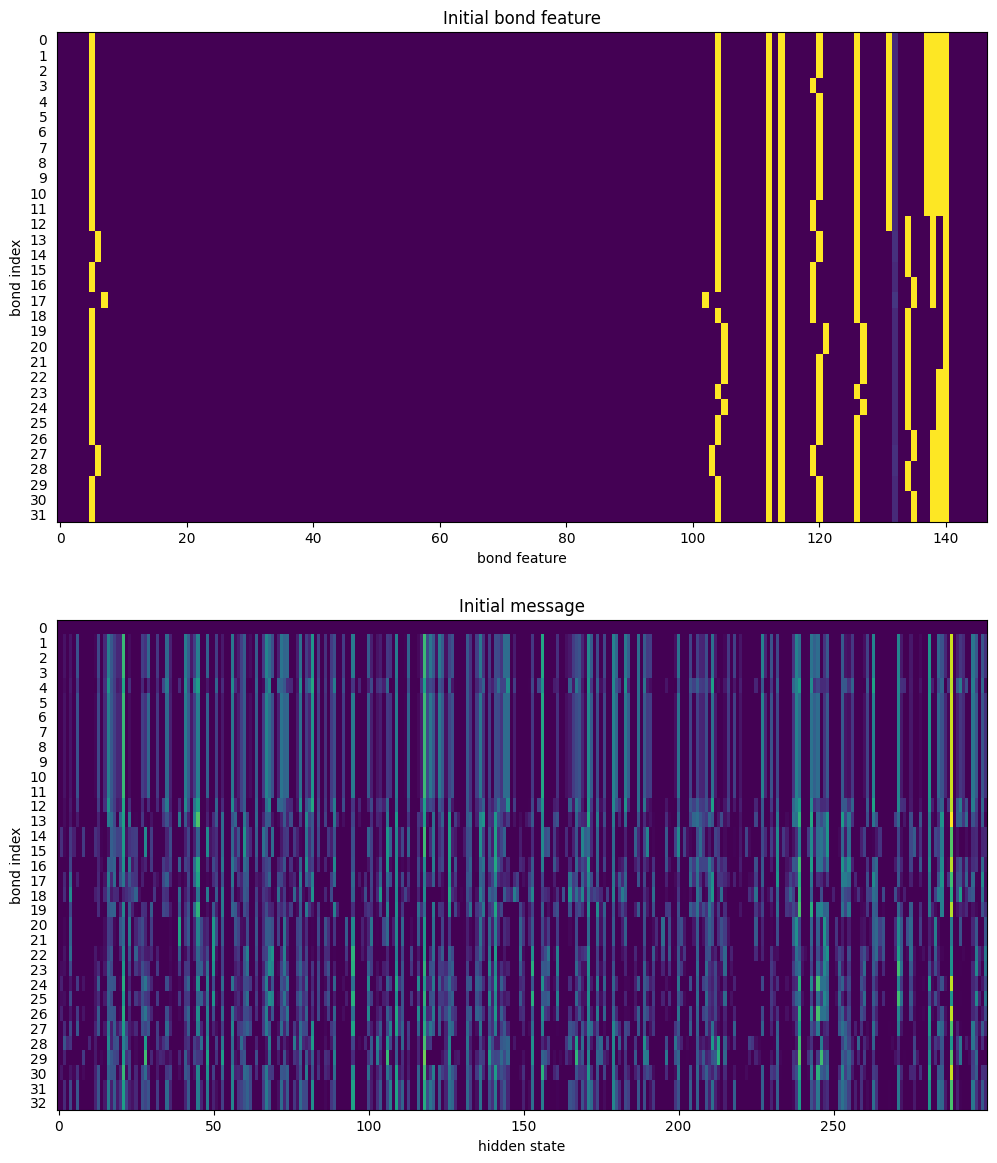

In [40]:
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(211)
im = ax.imshow(mol_graph.f_bonds, interpolation='None', cmap='viridis', aspect='auto')
ax.set_yticks(list(range(mol_graph.n_bonds)))
ax.set_yticklabels(list(range(mol_graph.n_bonds)))
ax.tick_params(left=False)  # remove the ticks
plt.xlabel('bond feature')
plt.ylabel('bond index')
plt.title('Initial bond feature')

ax = fig.add_subplot(212)
im = ax.imshow(message.detach().numpy(), interpolation='None', cmap='viridis', aspect='auto')
ax.set_yticks(list(range(mol_graph.n_bonds + 1)))
ax.set_yticklabels(list(range(mol_graph.n_bonds + 1)))
ax.tick_params(left=False)  # remove the ticks
plt.xlabel('hidden state')
plt.ylabel('bond index')
plt.title('Initial message')
plt.show()

Above is the representation of the features after the initial message, now I will try 3 cycles of message passing and see the change.

In [41]:
def index_select_ND(source: torch.Tensor, index: torch.Tensor) -> torch.Tensor: 
    """Selects the message features from source corresponding to the atom or bond indices in index. """ 
    index_size = index.size() # (num_atoms/num_bonds, max_num_bonds) 
    suffix_dim = source.size()[1:] # (hidden_size,) 
    final_size = index_size + suffix_dim # (num_atoms/num_bonds, max_num_bonds, hidden_size)

    target = source.index_select(dim=0, index=index.view(-1)) # (num_atoms/num_bonds * max_num_bonds, hidden_size)
    target = target.view(final_size)                          # (num_atoms/num_bonds, max_num_bonds, hidden_size)
    return target

In [42]:
for depth in range(3):

    # m(a1 -> a2) = [sum_{a0 \in nei(a1)} m(a0 -> a1)] - m(a2 -> a1)
    # message      a_message = sum(nei_a_message)      rev_message
    nei_a_message = index_select_ND(message, a2b)  # num_atoms x max_num_bonds x hidden
    a_message = nei_a_message.sum(dim=1)           # num_atoms x hidden
    rev_message = message[b2revb]                  # num_bonds x hidden
    message = a_message[b2a] - rev_message         # num_bonds x hidden
    message = W_h(message)
    message = act_func(input + message)            # num_bonds x hidden_size

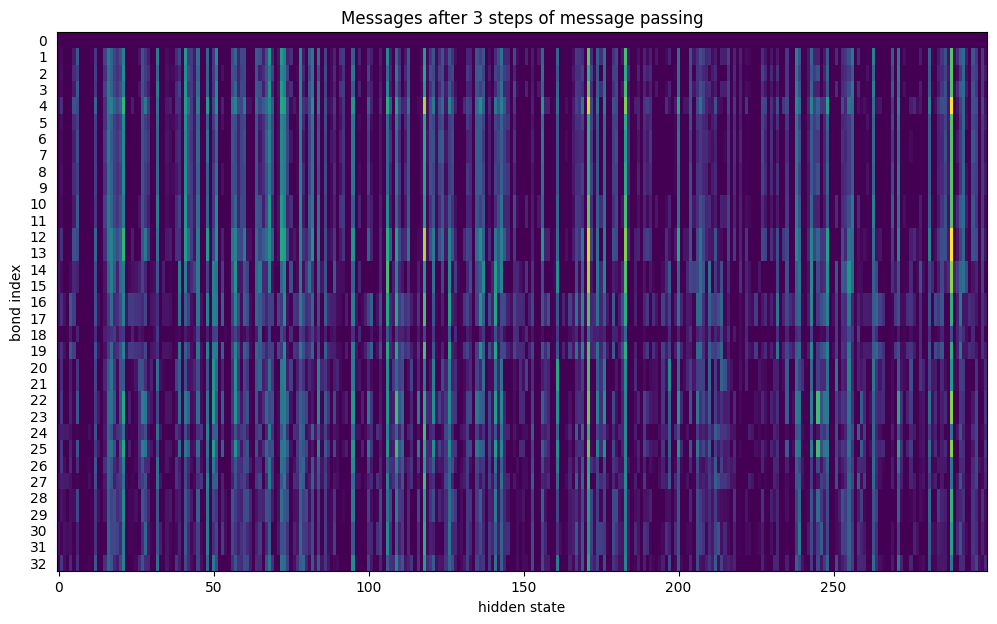

In [43]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
im = ax.imshow(a_message[b2a].detach().numpy(), interpolation='None', cmap='viridis', aspect='auto')

ax.set_yticks(list(range(mol_graph.n_bonds + 1)))
ax.set_yticklabels(list(range(mol_graph.n_bonds + 1)))
ax.tick_params(left=False)  # remove the ticks
plt.xlabel('hidden state')
plt.ylabel('bond index')
plt.title('Messages after 3 steps of message passing')
plt.show()

As seen, the representation of the hidden states have changed significantly during the 3 cycles of message passing.

Now that the overall idea of how an MPNN works is clear, I will train a model on a dataset and analyze its accuracy

## Creating the dataset

The dataset that I use for this implementation is the Enamine Real's diversity discovery set composed of 10240 compounds. This dataset contains some molecular properties, such as ClogP and TPSA, so we should be able to train a GCNN that predicts those properties. For this example, I'll train the model using ClogP values.

In [44]:
# Load the dataset
df = pd.read_csv('../data/enamine_discovery_diversity_set_10240.csv')
df.head()

,SMILES,MW (desalted),ClogP,HBD,TPSA,RotBonds
0,CN(C(=O)NC1CCOc2ccccc21)C(c1ccccc1)c1ccccn1,373.448,2.419,1,54.46,4
1,Cn1cc(C(=O)N2CCC(OC3CCOC3)CC2)c(C2CC2)n1,319.399,-0.570,0,56.59,4
2,CC(=O)N(C)C1CCN(C(=O)c2ccccc2-c2ccccc2C(=O)O)CC1,380.437,0.559,1,77.92,4
3,COCC1(CNc2cnccc2C#N)CCNCC1,260.335,0.902,2,69.97,5
4,CCCCOc1ccc(-c2nnc3n2CCCC3)cc1OC,301.383,3.227,0,49.17,6


In [45]:
# prepare data set
data = MoleculeDataset([
    MoleculeDatapoint(
        smiles=row[args.smiles_column],  # SMILES string from the DataFrame
        targets=[row[args.target_column]]  # Target property from the DataFrame
    ) for i, row in df.iterrows()  # Iterating over each row in the DataFrame
])

# Split data into training, validation, and testing sets
# Random state for reproducibility and shuffling
random = Random()

# Define proportions for training, validation, and testing
sizes = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test

# Generate indices and shuffle them to randomize data points before splitting
indices = list(range(len(data)))
random.shuffle(indices)

# Calculate split indices
train_size = int(sizes[0] * len(data))
train_val_size = int((sizes[0] + sizes[1]) * len(data))

# Slice the shuffled indices to create training, validation, and testing datasets
train = [data[i] for i in indices[:train_size]]
val = [data[i] for i in indices[train_size:train_val_size]]
test = [data[i] for i in indices[train_val_size:]]

# Wrap the lists of data points in MoleculeDataset objects for ease of use with PyTorch DataLoader
train_data = MoleculeDataset(train)
val_data = MoleculeDataset(val)
test_data = MoleculeDataset(test)

## Defining the Model

In [46]:
def initialize_weights(model: nn.Module) -> None:
    """Initializes the weights of a model in place.
    """
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)

In [47]:
class MPNEncoder(nn.Module):
    """
    A PyTorch module for encoding molecular graphs using a Message Passing Neural Network (MPN).
    This encoder uses a combination of linear transformations and non-linear activations to process
    the graph structure of molecules for downstream prediction tasks.

    Attributes:
        atom_fdim (int): The feature dimension of each atom.
        bond_fdim (int): The feature dimension of each bond.
        hidden_size (int): The size of the hidden layers.
        bias (bool): Whether to add a bias term in the linear transformations.
        depth (int): The number of message passing iterations.
        dropout (float): Dropout rate for regularization during training.
        layers_per_message (int): Number of layers per message passing iteration (currently set statically to 1).
        undirected (bool): Whether the molecular graph is undirected (currently not used).
        atom_messages (bool): Whether messages are being passed at the atom level (currently not used).
        device (torch.device): The device (CPU or GPU) on which computations will be performed.
        aggregation (str): The method of aggregating messages ('mean', 'sum', 'norm').
        aggregation_norm (int): Normalization constant used when aggregation is 'norm'.

    Methods:
        forward(mol_graph): Processes a batch of molecular graphs and returns their vector representations.
    """

    def __init__(self, args, atom_fdim, bond_fdim):
        super(MPNEncoder, self).__init__()
        self.atom_fdim = atom_fdim
        self.bond_fdim = bond_fdim
        self.hidden_size = args.hidden_size
        self.bias = args.bias
        self.depth = args.depth
        self.dropout = args.dropout
        self.layers_per_message = 1
        self.undirected = False
        self.atom_messages = False
        self.device = args.device
        self.aggregation = args.aggregation
        self.aggregation_norm = args.aggregation_norm

        # Layers
        self.dropout_layer = nn.Dropout(p=self.dropout)
        self.act_func = nn.ReLU()
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Weight matrices for input and hidden layers
        self.W_i = nn.Linear(self.bond_fdim, self.hidden_size, bias=self.bias)
        self.W_h = nn.Linear(self.hidden_size, self.hidden_size, bias=self.bias)
        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)

    def forward(self, mol_graph):
        """
        Forward pass of the MPNEncoder.

        Args:
            mol_graph (BatchMolGraph): A batch of molecular graphs to encode.

        Returns:
            torch.Tensor: A tensor of molecular vectors, each representing a molecule in the batch.
        """
        # Extract graph components
        f_atoms, f_bonds, a2b, b2a, b2revb, a_scope, b_scope = mol_graph.get_components()
        f_atoms, f_bonds, a2b, b2a, b2revb = f_atoms.to(self.device), f_bonds.to(self.device), a2b.to(self.device), b2a.to(self.device), b2revb.to(self.device)

        # Initial message passing
        input = self.W_i(f_bonds)
        message = self.act_func(input)

        # Iterative message passing
        for depth in range(self.depth - 1):
            nei_a_message = index_select_ND(message, a2b)
            a_message = nei_a_message.sum(dim=1)
            rev_message = message[b2revb]
            message = self.W_h(a_message[b2a] - rev_message)
            message = self.act_func(input + message)
            message = self.dropout_layer(message)

        # Aggregating messages to atom vectors
        nei_a_message = index_select_ND(message, a2b)
        a_message = nei_a_message.sum(dim=1)
        a_input = torch.cat([f_atoms, a_message], dim=1)
        atom_hiddens = self.act_func(self.W_o(a_input))
        atom_hiddens = self.dropout_layer(atom_hiddens)

        # Readout phase to combine atom vectors into molecule vectors
        mol_vecs = []
        for i, (a_start, a_size) in enumerate(a_scope):
            if a_size == 0:
                mol_vecs.append(self.cached_zero_vector)
            else:
                cur_hiddens = atom_hiddens.narrow(0, a_start, a_size)
                mol_vec = cur_hiddens
                if self.aggregation == 'mean':
                    mol_vec = mol_vec.sum(dim=0) / a_size
                elif self.aggregation == 'sum':
                    mol_vec = mol_vec.sum(dim=0)
                elif self.aggregation == 'norm':
                    mol_vec = mol_vec.sum(dim=0) / self.aggregation_norm
                mol_vecs.append(mol_vec)

        mol_vecs = torch.stack(mol_vecs, dim=0)

        return mol_vecs

In [54]:
class MPN(nn.Module):
    """
    Message Passing Network (MPN) for encoding molecular graphs into a vector representation.

    This class wraps the MPNEncoder and provides an interface to process batches of molecular graphs, converting them into fixed-size embeddings that can be used for downstream tasks like property prediction.

    Attributes:
        atom_fdim (int): The feature dimension for atoms, automatically determined if not provided.
        bond_fdim (int): The feature dimension for bonds, automatically determined if not provided.
        device (torch.device): The device on which to perform calculations (CPU or GPU).
        encoder (MPNEncoder): The encoder that performs the message passing and encoding logic.

    Methods:
        forward(batch): Processes a batch of molecules through the encoder and aggregates the results.
    """

    def __init__(self, args, atom_fdim=None, bond_fdim=None):
        """
        Initializes the MPN model with the necessary settings and sub-models.
        
        Args:
            args: Configuration arguments which contain settings like the device and dimensions.
            atom_fdim (int, optional): The feature dimension for atoms. If None, uses a default function.
            bond_fdim (int, optional): The feature dimension for bonds. If None, uses a default function.
        """
        super(MPN, self).__init__()
        self.atom_fdim = atom_fdim or get_atom_fdim()  # Set atom feature dimension
        self.bond_fdim = bond_fdim or get_bond_fdim()  # Set bond feature dimension
        self.device = args.device  # Device configuration
        self.encoder = MPNEncoder(args, self.atom_fdim, self.bond_fdim)  # Initialize the encoder

    def forward(self, batch):
        """
        Forward pass through the network which processes a batch of molecular data.

        Args:
            batch (list): A batch of data that needs to be processed. Each element can be a molecule graph or data structure that the encoder can process.

        Returns:
            torch.Tensor: A tensor containing the encoded representations of the batch.
        """
        # Ensure that each item in the batch is a MolGraph; if not, convert it
        if type(batch[0]) != BatchMolGraph:
            batch = [mol2graph(b) for b in batch]  # Convert data to MolGraph if necessary

        # Encode the batch using the MPNEncoder
        encodings = [self.encoder(batch[0])]
        # Combine encodings if there are multiple (this example assumes a single encoding for simplicity)
        output = reduce(lambda x, y: torch.cat((x, y), dim=1), encodings)
        return output

In [65]:
class MolGraphNet(nn.Module):
    """
    The primary model for molecular property prediction, integrating the MPN encoder and a fully connected feed-forward network (FFN) for final prediction.

    Attributes:
        classification (bool): Indicates if the model is used for classification tasks.
        featurizer (bool): Flag to determine if the model should act as a featurizer, i.e., outputting features rather than predictions.
        output_size (int): The number of output targets or classes.
        sigmoid (nn.Module, optional): Sigmoid activation, used in the output layer for classification tasks.
        encoder (MPN): An instance of the MPN class, which encodes molecular graphs.
        ffn (nn.Sequential): The feed-forward network that processes encoded molecular features into final predictions.

    Methods:
        create_encoder(args): Initializes the MPN encoder.
        create_ffn(args): Constructs the feed-forward layers based on the provided arguments.
        featurize(batch, features_batch=None, atom_descriptors_batch=None): Generates features from the input batch using the model.
        forward(batch): Processes input through the encoder and FFN to produce predictions or features.
    """

    def __init__(self, args, featurizer=False):
        super(MolGraphNet, self).__init__()
        self.classification = args.dataset_type == 'classification'
        self.featurizer = featurizer
        self.output_size = args.num_tasks

        if self.classification:
            self.sigmoid = nn.Sigmoid()  # Activation function for binary classification output

        # Initialize the components of the model
        self.create_encoder(args)
        self.create_ffn(args)
        initialize_weights(self)  # Custom function to initialize model weights

    def create_encoder(self, args):
        """
        Initializes the encoder component of the model using the MPN architecture.
        """
        self.encoder = MPN(args)

    def create_ffn(self, args):
        """
        Constructs the feed-forward network using the specifications provided in args.

        Args:
            args: Configuration arguments containing network settings.
        """
        first_linear_dim = args.hidden_size
        dropout = nn.Dropout(args.dropout)
        activation = nn.ReLU()

        # Build the FFN architecture dynamically based on the number of layers specified
        if args.ffn_num_layers == 1:
            ffn = [dropout, nn.Linear(first_linear_dim, self.output_size)]
        else:
            ffn = [dropout, nn.Linear(first_linear_dim, args.ffn_hidden_size)]
            for _ in range(args.ffn_num_layers - 2):
                ffn.extend([activation, dropout, nn.Linear(args.ffn_hidden_size, args.ffn_hidden_size)])
            ffn.extend([activation, dropout, nn.Linear(args.ffn_hidden_size, self.output_size)])

        self.ffn = nn.Sequential(*ffn)  # Wrap the list of layers into a Sequential container

    def featurize(self, batch, features_batch=None, atom_descriptors_batch=None):
        """
        Generates feature vectors from the input batch, omitting the final prediction layer.

        Args:
            batch: The batch of data to process.
            features_batch: Optional additional features to be included.
            atom_descriptors_batch: Optional atomic descriptors to be included.

        Returns:
            Tensor: The feature vectors for the batch.
        """
        return self.ffn[:-1](self.encoder(batch))  # Exclude the last layer (prediction layer)

    def forward(self, batch):
        """
        Defines the forward pass through the model.

        Args:
            batch: The batch of molecular graphs to be processed.

        Returns:
            Tensor: The output predictions or class probabilities.
        """
        output = self.ffn(self.encoder(batch))
        if self.classification and not self.training:
            output = self.sigmoid(output)  # Apply sigmoid for classification to get probabilities
        return output

In [66]:
model = MolGraphNet(args)
model = model.to(args.device)

In [67]:
model

MolGraphNet(
  (encoder): MPN(
    (encoder): MPNEncoder(
      (dropout_layer): Dropout(p=0.0, inplace=False)
      (act_func): ReLU()
      (W_i): Linear(in_features=147, out_features=300, bias=False)
      (W_h): Linear(in_features=300, out_features=300, bias=False)
      (W_o): Linear(in_features=433, out_features=300, bias=True)
    )
  )
  (ffn): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)

In [68]:
class NoamLR(_LRScheduler):
    """
    Implements a learning rate scheduler that adjusts the learning rate according to the Noam scheme.
    It starts with a linear warm-up phase, followed by an exponential decay.

    Attributes:
        optimizer (Optimizer): The optimizer for which to adjust the learning rate.
        warmup_epochs (list of floats or ints): Number of epochs during which the learning rate increases.
        total_epochs (list of ints): Total number of epochs for training.
        steps_per_epoch (int): Number of batches (steps) per epoch.
        init_lr (list of floats): Initial learning rates for each parameter group.
        max_lr (list of floats): Maximum learning rates during the warm-up.
        final_lr (list of floats): Final learning rates after decay.
    """

    def __init__(self, optimizer, warmup_epochs, total_epochs, steps_per_epoch, init_lr, max_lr, final_lr):
        """
        Initializes the NoamLR scheduler.

        Args:
            optimizer (Optimizer): Bound optimizer.
            warmup_epochs (list of float|int): Epochs to linearly increase the learning rate.
            total_epochs (list of int): Total duration of training to adjust learning rate.
            steps_per_epoch (int): Number of optimizer updates per epoch.
            init_lr (list of float): Initial learning rates for each parameter group.
            max_lr (list of float): Peak learning rates to reach after warmup.
            final_lr (list of float): Learning rates to decay towards by the end of training.
        """
        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == \
               len(init_lr) == len(max_lr) == len(final_lr), "Length of constructor arguments must match."

        self.num_lrs = len(optimizer.param_groups)
        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self):
        """
        Computes and returns the current learning rate for each parameter group.
        """
        return list(self.lr)

    def step(self, current_step=None):
        """
        Update the learning rate after each batch iteration.

        Args:
            current_step (int, optional): Optionally specify the current training step. If not provided,
            the internal step counter is used and incremented.
        """
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]

In [69]:
def construct_molecule_batch(data):
    """
    Prepare and process a batch of molecular data for use in a DataLoader.

    This function takes a list of data points, wraps them into a MoleculeDataset object,
    and ensures that all necessary graph computations for the batch are performed in advance.

    Args:
        data (list): A list of molecular data points.

    Returns:
        MoleculeDataset: A dataset object with precomputed graph representations.
    """
    data = MoleculeDataset(data)
    data.batch_graph()  # Ensures all molecular graphs are processed and ready for model input
    return data

In [70]:
class MoleculeSampler(Sampler):
    """
    Custom sampler for molecular datasets, supporting optional shuffling.

    Attributes:
        dataset (Dataset): The dataset from which to sample.
        shuffle (bool): Whether to shuffle the data every epoch.
        _random (Random): Random number generator for shuffling.
        length (int): Number of items in the dataset.

    Methods:
        __iter__: Returns an iterator over the dataset indices.
        __len__: Returns the number of items in the dataset.
    """
    def __init__(self, dataset, shuffle=False, seed=0):
        super(Sampler, self).__init__()
        self.dataset = dataset
        self.shuffle = shuffle
        self._random = Random(seed)  # Random generator for shuffling
        self.length = len(self.dataset)  # Store dataset length for easy access

    def __iter__(self):
        indices = list(range(len(self.dataset)))
        if self.shuffle:
            self._random.shuffle(indices)  # Shuffle indices if required
        return iter(indices)  # Return iterator over indices

    def __len__(self):
        return self.length  # Return the length of the dataset

In [73]:
class MoleculeDataLoader(DataLoader):
    """
    DataLoader for handling molecular data with specific needs like batch processing and optional shuffling.

    Extends PyTorch DataLoader, configuring it specifically for molecular datasets using a custom sampler
    and data preparation function.

    Attributes:
        _dataset (MoleculeDataset): The dataset to load.
        _batch_size (int): Number of items per batch.
        _num_workers (int): Number of subprocesses to use for data loading.
        _shuffle (bool): Whether to shuffle the data at every epoch.
        _seed (int): Random seed for shuffling.
        _context (str, optional): Multiprocessing context, set to 'forkserver' if not the main thread to avoid hangs.
        _timeout (int): Timeout for collecting a batch from workers.
        _sampler (Sampler): Custom sampler to manage the sampling of data indices based on shuffling and seeding.

    Methods:
        targets: Property that attempts to return targets from the dataset unless shuffling or class balance is active.
        iter_size: Property returning the size of an iterator over the dataset.
        __iter__: Provides an iterator over batches of data.
    """
    def __init__(self,
                 dataset: MoleculeDataset,
                 batch_size: int = 50,
                 num_workers: int = 8,
                 shuffle: bool = False,
                 seed: int = 0):

        self._dataset = dataset
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._shuffle = shuffle
        self._seed = seed
        self._context = None
        self._class_balance = False
        self._timeout = 0
        is_main_thread = threading.current_thread() is threading.main_thread()
        
        if not is_main_thread and self._num_workers > 0:
            self._context = 'forkserver'  # In order to prevent a hanging
            self._timeout = 3600  # Just for sure that the DataLoader won't hang

        self._sampler = MoleculeSampler(
            dataset=self._dataset,
            shuffle=self._shuffle,
            seed=self._seed
        )

        super(MoleculeDataLoader, self).__init__(
            dataset=self._dataset,
            batch_size=self._batch_size,
            sampler=self._sampler,
            num_workers=self._num_workers,
            collate_fn=construct_molecule_batch,
            multiprocessing_context=self._context,
            timeout=self._timeout
        )

    @property
    def targets(self):
        """
        Retrieves targets from the dataset unless shuffle is enabled, in which case raising an error.
        
        Returns:
            List[List[Optional[float]]]: List of target values from the dataset.

        Raises:
            ValueError: If data shuffling is enabled, as target retrieval might not be safe.
        """
        if self._class_balance or self._shuffle:
            raise ValueError('Cannot safely extract targets when class balance or shuffle are enabled.')
        return [self._dataset[index].targets for index in self._sampler]

    @property
    def iter_size(self):
        """Returns the number of items that can be iterated over."""
        return len(self._sampler)

    def __iter__(self):
        """Provides an iterator over the batches of data."""
        return super(MoleculeDataLoader, self).__iter__()

## Model Training and Evaluation

In [74]:
# Initialize the training data loader
train_data_loader = MoleculeDataLoader(
    dataset=train_data,  # The training dataset prepared earlier
    batch_size=args.batch_size,  # Number of samples per batch as specified in arguments
    num_workers=0,  # Number of worker processes to use for data loading
    shuffle=True,  # Enable shuffling to randomize the order of data for each epoch
    seed=args.seed  # Seed for the random number generator used in shuffling
)

# Initialize the validation data loader
val_data_loader = MoleculeDataLoader(
    dataset=val_data,  # The validation dataset prepared earlier
    batch_size=args.batch_size,  # Number of samples per batch, consistent with the training loader
    num_workers=0,  # Validation typically requires less parallelism, hence set to 0
    shuffle=False  # Shuffling not necessary for validation runs
)

# Initialize the testing data loader
test_data_loader = MoleculeDataLoader(
    dataset=test_data,  # The testing dataset prepared earlier
    batch_size=args.batch_size,  # Consistent batch size across all loaders
    num_workers=0,  # Similar to validation, parallelism is less of a concern during testing
    shuffle=False  # Shuffling is generally not applied during testing to maintain predictable order
)

In [75]:
# optimizer
params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = Adam(params)

# scheduler
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_data) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

# loss function
loss_func = nn.MSELoss(reduction='none')

In [76]:
# train loop
model.train()
loss_sum = iter_count = 0
n_iter = 0

for batch in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
    mol_batch, target_batch = batch.batch_graph(), batch.targets()
    mask = torch.Tensor([[x is not None for x in tb] for tb in target_batch])
    targets = torch.Tensor([[0 if x is None else x for x in tb] for tb in target_batch])

    # Run model
    model.zero_grad()
    preds = model(mol_batch)

    # Move tensors to correct device
    mask = mask.to(preds.device)
    targets = targets.to(preds.device)
    class_weights = torch.ones(targets.shape, device=preds.device)

    loss = loss_func(preds, targets) * class_weights * mask
    loss = loss.sum() / mask.sum()

    loss_sum += loss.item()
    iter_count += 1

    loss.backward()

    optimizer.step()

    if isinstance(scheduler, NoamLR):
        scheduler.step()

    n_iter += len(batch)

  0%|          | 0/164 [00:00<?, ?it/s]

In [77]:
model.eval()

initial_preds = []

for batch in tqdm(val_data_loader, disable=False, leave=False):
    # Prepare batch
    batch: MoleculeDataset
    mol_batch = batch.batch_graph()

    # Make predictions
    with torch.no_grad():
        batch_preds = model(mol_batch)

    batch_preds = batch_preds.data.cpu().numpy()

    # Collect vectors
    batch_preds = batch_preds.tolist()
    initial_preds.extend(batch_preds)

  0%|          | 0/21 [00:00<?, ?it/s]

In [78]:
# valid_preds and valid_targets have shape (num_tasks, data_size)
targets = val_data_loader.targets
metric_func = mean_squared_error

valid_preds = [[] for _ in range(args.num_tasks)]
valid_targets = [[] for _ in range(args.num_tasks)]
for i in range(args.num_tasks):
    for j in range(len(preds)):
        if targets[j][i] is not None:  # Skip those without targets
            valid_preds[i].append(preds[j][i].detach())
            valid_targets[i].append(targets[j][i])
            
result = metric_func(valid_targets[i], valid_preds[i])
print('MSE:', result)

MSE: 0.9714913243957197


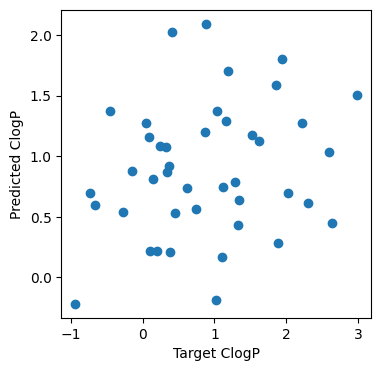

In [79]:
fit = plt.figure(figsize=(4,4))
plt.scatter(valid_targets[i], valid_preds[i])
plt.xlabel('Target ClogP')
plt.ylabel('Predicted ClogP')
plt.show()

In [80]:
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_data) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

loss_func = nn.MSELoss(reduction='none')

optimizer = Adam(params)

metric_func = mean_squared_error


for epoch in tqdm(range(args.epochs)):

    # train 
    model.train()

    loss_sum = iter_count = 0
    n_iter = 0

    for batch in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
        mol_batch, target_batch = batch.batch_graph(), batch.targets()
        mask = torch.Tensor([[x is not None for x in tb] for tb in target_batch])
        targets = torch.Tensor([[0 if x is None else x for x in tb] for tb in target_batch])

        # Run model
        model.zero_grad()
        preds = model(mol_batch)

        # Move tensors to correct device
        mask = mask.to(preds.device)
        targets = targets.to(preds.device)
        class_weights = torch.ones(targets.shape, device=preds.device)

        loss = loss_func(preds, targets) * class_weights * mask
        loss = loss.sum() / mask.sum()

        loss_sum += loss.item()
        iter_count += 1

        loss.backward()

        optimizer.step()

        if isinstance(scheduler, NoamLR):
            scheduler.step()

        n_iter += len(batch)

    # eval

    model.eval()

    preds = []

    for batch in tqdm(val_data_loader, disable=False, leave=False):
        # Prepare batch
        batch: MoleculeDataset
        mol_batch = batch.batch_graph()

        # Make predictions
        with torch.no_grad():
            batch_preds = model(mol_batch)

        batch_preds = batch_preds.data.cpu().numpy()

        # Collect vectors
        batch_preds = batch_preds.tolist()
        preds.extend(batch_preds)

    # valid_preds and valid_targets have shape (num_tasks, data_size)
    num_tasks = 1
    targets = val_data_loader.targets

    valid_preds = [[] for _ in range(num_tasks)]
    valid_targets = [[] for _ in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(len(preds)):
            if targets[j][i] is not None:  # Skip those without targets
                valid_preds[i].append(preds[j][i])
                valid_targets[i].append(targets[j][i])

    result = metric_func(valid_targets[i], valid_preds[i])
    print(epoch, result)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0 0.5772808499420496


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1 0.43730039435150747


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

2 0.2999155588001612


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

3 0.38617071961284394


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

4 0.2431001627615551


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

5 0.22250087987129819


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

6 0.27009094361694397


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

7 0.17074697101080466


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

8 0.1537760813359048


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

9 0.16153722711365623


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

10 0.14878091134202112


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

11 0.15343669379347274


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

12 0.12234872828892128


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

13 0.15377137792944434


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

14 0.12967612719340793


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

15 0.13900518967113087


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

16 0.10833532356435613


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

17 0.1070458310020655


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

18 0.09986641785681823


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

19 0.0992832435689063


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

20 0.10114555542055348


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

21 0.09660189590006607


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

22 0.09447538077255699


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

23 0.08897792996559367


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

24 0.08840961862797689


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

25 0.08771897916508681


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

26 0.0893330046650033


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

27 0.09531497629446796


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

28 0.08453179971783348


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

29 0.08145344593754406


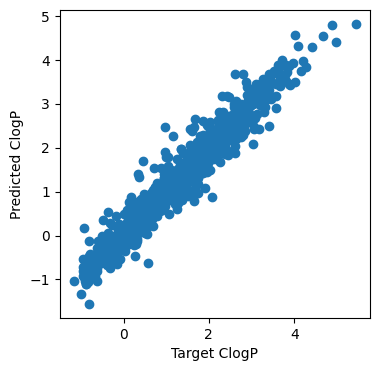

In [81]:
fit = plt.figure(figsize=(4,4))
plt.scatter(valid_targets[i], valid_preds[i])
plt.xlabel('Target ClogP')
plt.ylabel('Predicted ClogP')
plt.show()